In [ ]:
# import sys
# !{sys.executable} -m pip install numpy pandas matplotlib sklearn seaborn
# !{sys.executable} -m pip install --upgrade gensim
# !{sys.executable} -m pip install nltk
# !{sys.executable} -m pip install beautifulsoup4
# import nltk
# nltk.download('punkt')

In [1]:
import os
import re
import gensim
import multiprocessing
import random
import logging
import numpy as np
import zipfile
import pickle

import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

from urllib import request

from pathlib import Path
from os import listdir
from os.path import isfile, join
from nltk.tokenize import RegexpTokenizer
from bs4 import BeautifulSoup

from sklearn.cluster import KMeans
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [2]:
SKIP_FILES = ""
NEWLINE = '\n'

def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r",", " ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " ( ", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

"""
read training files
"""
def read_files(path):
    print("path: {}...".format(path))
    for root, dirnames, filenames in os.walk(path):
        for dirname in dirnames:
            read_files(os.path.join(root, dirname))
        for filename in filenames:
            if filename not in SKIP_FILES:
                filepath = os.path.join(root, filename)
                if os.path.isfile(filepath):
                    lines = []
                    f = open(filepath, encoding='latin-1')
                    for line in f:
                        lines.append(line)
                    f.close()
                    content = NEWLINE.join(lines)
                    yield filename, content

def download(url, filename, local):
    """Download a file if not present"""
    if not local and not os.path.exists(filename):
        print("downloading {}...".format(filename))
        filename, _ = request.urlretrieve(url + filename, filename)

        print("extracting {}...".format(filename))
        with zipfile.ZipFile(filename) as f:
            f.extractall()
            print("extracting {} done".format(filename))

    """directory data"""
    data_path = filename.replace('.zip','')
    if not os.path.exists(data_path):
        if os.path.exists(filename):
            print("extracting {}...".format(filename))
            with zipfile.ZipFile(filename) as f:
                f.extractall()
                print("extracting {} done".format(filename))
        else:
            print('data.zip not found!')

    """directory model for saving model while training"""
    if not os.path.exists('model'):
        os.mkdir('model')
        print("directory model created...")

    return data_path

In [3]:
def get_data(url, filename, local):
    data_path = download(url, filename, local)
    pid = 0
    pid_post_id = {}
    documents = []
    print("building documents...")
    for fname, text in read_files(data_path):
        post_id = fname.split('_')[0]
        pid_post_id[pid] = int(post_id)
        pid = pid + 1
        documents.append(clean_str(text).split(' '))
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(documents)]
    print("building documents done")
    return documents, pid_post_id

##### Download Data Training

In [4]:
documents, pid_post_id = get_data(url='https://github.com/kadriansyah/notebook/raw/master/alodokter-doc2vec-article/', filename="data.zip", local=True)
print("we have {} documents".format(len(documents)))
pickle.dump(pid_post_id, open('model/pid_post_id.pkl','wb'))

building documents...
path: data...
building documents done
we have 6058 documents


In [5]:
documents[0]

TaggedDocument(words=['cedera', 'tulang', 'tengkorak', 'bisa', 'berakibat', 'fatal', 'struktur', 'tulang', 'yang', 'membentuk', 'kepala', 'pada', 'kerangka', 'manusia', 'dikenal', 'dengan', 'nama', 'tulang', 'tengkorak', 'secara', 'umum', 'tulang', 'tengkorak', 'terdiri', 'dari', '2', 'bagian', 'yaitu', 'tulang', 'tengkorak', 'bagian', 'kepala', '(', 'tempurung', ')', 'dan', 'tulang', 'tengkorak', 'bagian', 'wajah', 'keberadaan', 'tulang', 'tengkorak', 'ini', 'berperan', 'penting', 'dalam', 'melindungi', 'otak', 'dan', 'mendukung', 'terbentuknya', 'struktur', 'wajah', 'tulang', 'tengkorak', 'tersusun', 'dari', 'beberapa', 'bagian', 'tulang', 'yaitu', 'tulang', 'rahang', 'atas', 'dan', 'bawah', 'tulang', 'zigoma', 'tulang', 'dahi', 'tulang', 'parietal', 'tulang', 'temporal', '(', 'pelipis', ')', 'tulang', 'oksipital', '(', 'belakang', 'kepala', ')', 'tulang', 'sphenoid', 'dan', 'tulang', 'ethmoid', 'kesemua', 'bagian', 'tulang', 'tengkorak', 'ini', 'disatukan', 'oleh', 'sebuah', 'jaring

In [6]:
def evaluate(model, documents, steps):
    percentiles = np.zeros(steps)
    for step in range(steps):
        docid = np.random.randint(model.docvecs.count)
        inferred_vector = model.infer_vector(documents[docid][0])
        similars = model.docvecs.most_similar(positive=[inferred_vector], topn=10)
        for idx,simdoc in enumerate(similars):
            if simdoc[0] == docid:
                print("found similar document with id {} in position {} with similarity score {}".format(simdoc[0], idx, simdoc[1]))
                percentiles[step] = ((len(similars) - idx) / len(similars)) * 100
                break
    return np.mean(percentiles)

def train(documents=documents, model_name="model/alodokter-articles-doc2vec.model", max_epochs=50, patience=3):
    best_mean_percentiles = 0
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    model = Doc2Vec(dm=1, vector_size=100, window=2, alpha=0.1, min_alpha=0.0001, min_count=5, epochs=1, workers=5)
    model.build_vocab(documents)
    for epoch in range(max_epochs):
        print('training epoch {:d} ...'.format(epoch))
        model.train(documents, total_examples=model.corpus_count,epochs=model.epochs)
        mean_percentiles = evaluate(model,documents,10)
        print('mean percentiles: {:.2f}'.format(mean_percentiles))
        
        if mean_percentiles < best_mean_percentiles:
            print("current mean_percentiles: {:.2f}, best: {:.2f}".format(mean_percentiles, best_mean_percentiles))
            patience = patience-1
        else:
            best_mean_percentiles = mean_percentiles
            print("========== Saving best model with mean_percentiles: {:.2f} ==========".format(mean_percentiles))
            model.save(model_name)
            patience = patience+1
        
        if patience == 0:
            print("early stop...")
            print("========== Saving best model with mean_percentiles: {:.2f} ==========".format(best_mean_percentiles))
            break
    
    return model

##### Document to Vector Training

In [7]:
training = True
if training:
    model = train(documents)
else:
    print('loading documents...')
    model = Doc2Vec.load('model/alodokter-articles-doc2vec.model')
    print('loading documents done')

# prepare vectors for training
trained_vectors = [model.docvecs[i] for i in range(len(model.docvecs))]

2020-03-10 16:46:38,752 : INFO : collecting all words and their counts
2020-03-10 16:46:38,753 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2020-03-10 16:46:39,239 : INFO : collected 43690 word types and 6058 unique tags from a corpus of 6058 examples and 3384196 words
2020-03-10 16:46:39,240 : INFO : Loading a fresh vocabulary
2020-03-10 16:46:39,266 : INFO : effective_min_count=5 retains 12703 unique words (29% of original 43690, drops 30987)
2020-03-10 16:46:39,267 : INFO : effective_min_count=5 leaves 3339565 word corpus (98% of original 3384196, drops 44631)
2020-03-10 16:46:39,300 : INFO : deleting the raw counts dictionary of 43690 items
2020-03-10 16:46:39,302 : INFO : sample=0.001 downsamples 51 most-common words
2020-03-10 16:46:39,302 : INFO : downsampling leaves estimated 2842147 word corpus (85.1% of prior 3339565)
2020-03-10 16:46:39,337 : INFO : estimated required memory for 12703 words and 100 dimensions: 18937100 bytes
2020-03-10 16:4

training epoch 0 ...


2020-03-10 16:46:43,182 : INFO : EPOCH 1 - PROGRESS: at 70.37% examples, 1994373 words/s, in_qsize 9, out_qsize 0
2020-03-10 16:46:43,607 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-10 16:46:43,609 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-10 16:46:43,614 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-10 16:46:43,620 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-10 16:46:43,620 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-10 16:46:43,621 : INFO : EPOCH - 1 : training on 3384196 raw words (2848617 effective words) took 1.4s, 1974530 effective words/s
2020-03-10 16:46:43,621 : INFO : training on a 3384196 raw words (2848617 effective words) took 1.4s, 1970521 effective words/s
2020-03-10 16:46:43,622 : INFO : precomputing L2-norms of doc weight vectors
2020-03-10 16:46:43,648 : INFO : saving Doc2Vec object under model/alodokter-articles-do

found similar document with id 2520 in position 0 with similarity score 0.5862585306167603
found similar document with id 3483 in position 0 with similarity score 0.7100953459739685
found similar document with id 1956 in position 0 with similarity score 0.6895844340324402
found similar document with id 673 in position 0 with similarity score 0.5658156871795654
found similar document with id 4715 in position 0 with similarity score 0.7635135650634766
found similar document with id 1723 in position 0 with similarity score 0.6899625062942505
found similar document with id 1559 in position 0 with similarity score 0.5971599817276001
found similar document with id 2352 in position 0 with similarity score 0.7353086471557617
found similar document with id 5663 in position 0 with similarity score 0.5780805349349976
found similar document with id 5205 in position 0 with similarity score 0.7633049488067627
mean percentiles: 100.00
========== Saving best model with mean_percentiles: 100.00 =======

2020-03-10 16:46:44,789 : INFO : EPOCH 1 - PROGRESS: at 51.27% examples, 1441316 words/s, in_qsize 9, out_qsize 1
2020-03-10 16:46:45,567 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-10 16:46:45,570 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-10 16:46:45,574 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-10 16:46:45,578 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-10 16:46:45,579 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-10 16:46:45,580 : INFO : EPOCH - 1 : training on 3384196 raw words (2847451 effective words) took 1.8s, 1589942 effective words/s
2020-03-10 16:46:45,580 : INFO : training on a 3384196 raw words (2847451 effective words) took 1.8s, 1587390 effective words/s
2020-03-10 16:46:45,597 : WARNING : Effective 'alpha' higher than previous training cycles
2020-03-10 16:46:45,598 : INFO : training model with 5 workers on 12703 vo

found similar document with id 5952 in position 0 with similarity score 0.669477641582489
found similar document with id 5069 in position 0 with similarity score 0.7786310911178589
found similar document with id 1277 in position 0 with similarity score 0.6632604598999023
found similar document with id 2962 in position 0 with similarity score 0.6292350888252258
found similar document with id 4756 in position 0 with similarity score 0.6452072262763977
found similar document with id 5262 in position 0 with similarity score 0.5334734916687012
found similar document with id 2164 in position 0 with similarity score 0.6893901824951172
found similar document with id 1838 in position 0 with similarity score 0.7599241137504578
found similar document with id 2722 in position 0 with similarity score 0.5565013885498047
found similar document with id 1588 in position 1 with similarity score 0.6015482544898987
mean percentiles: 99.00
current mean_percentiles: 99.00, best: 100.00
training epoch 2 ...


2020-03-10 16:46:46,602 : INFO : EPOCH 1 - PROGRESS: at 42.21% examples, 1188876 words/s, in_qsize 9, out_qsize 1
2020-03-10 16:46:47,455 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-10 16:46:47,457 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-10 16:46:47,460 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-10 16:46:47,466 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-10 16:46:47,467 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-10 16:46:47,468 : INFO : EPOCH - 1 : training on 3384196 raw words (2848299 effective words) took 1.9s, 1526194 effective words/s
2020-03-10 16:46:47,469 : INFO : training on a 3384196 raw words (2848299 effective words) took 1.9s, 1523076 effective words/s
2020-03-10 16:46:47,491 : WARNING : Effective 'alpha' higher than previous training cycles
2020-03-10 16:46:47,492 : INFO : training model with 5 workers on 12703 vo

found similar document with id 1594 in position 0 with similarity score 0.682748556137085
found similar document with id 5031 in position 0 with similarity score 0.6878296136856079
found similar document with id 5083 in position 0 with similarity score 0.7073346972465515
found similar document with id 1120 in position 0 with similarity score 0.566311240196228
found similar document with id 3854 in position 0 with similarity score 0.7848774194717407
found similar document with id 2910 in position 0 with similarity score 0.7352684140205383
found similar document with id 4636 in position 0 with similarity score 0.7815603017807007
found similar document with id 5354 in position 0 with similarity score 0.7506122589111328
found similar document with id 3336 in position 0 with similarity score 0.7234679460525513
mean percentiles: 90.00
current mean_percentiles: 90.00, best: 100.00
training epoch 3 ...


2020-03-10 16:46:48,500 : INFO : EPOCH 1 - PROGRESS: at 66.16% examples, 1865673 words/s, in_qsize 9, out_qsize 0
2020-03-10 16:46:48,994 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-10 16:46:48,996 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-10 16:46:48,997 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-10 16:46:49,002 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-10 16:46:49,005 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-10 16:46:49,006 : INFO : EPOCH - 1 : training on 3384196 raw words (2847680 effective words) took 1.5s, 1886442 effective words/s
2020-03-10 16:46:49,006 : INFO : training on a 3384196 raw words (2847680 effective words) took 1.5s, 1881958 effective words/s
2020-03-10 16:46:49,026 : WARNING : Effective 'alpha' higher than previous training cycles
2020-03-10 16:46:49,026 : INFO : training model with 5 workers on 12703 vo

found similar document with id 5864 in position 0 with similarity score 0.7480736970901489
found similar document with id 3626 in position 0 with similarity score 0.7362589836120605
found similar document with id 1270 in position 0 with similarity score 0.6037477254867554
found similar document with id 3029 in position 0 with similarity score 0.6897852420806885
found similar document with id 1142 in position 1 with similarity score 0.5890432596206665
found similar document with id 4467 in position 0 with similarity score 0.6919130086898804
found similar document with id 4093 in position 0 with similarity score 0.6176135540008545
found similar document with id 2433 in position 0 with similarity score 0.6269265413284302
found similar document with id 4284 in position 0 with similarity score 0.7136954069137573
mean percentiles: 89.00
current mean_percentiles: 89.00, best: 100.00
training epoch 4 ...


2020-03-10 16:46:50,033 : INFO : EPOCH 1 - PROGRESS: at 65.57% examples, 1853000 words/s, in_qsize 9, out_qsize 0
2020-03-10 16:46:50,544 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-10 16:46:50,547 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-10 16:46:50,549 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-10 16:46:50,556 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-10 16:46:50,558 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-10 16:46:50,559 : INFO : EPOCH - 1 : training on 3384196 raw words (2848549 effective words) took 1.5s, 1863770 effective words/s
2020-03-10 16:46:50,560 : INFO : training on a 3384196 raw words (2848549 effective words) took 1.5s, 1858552 effective words/s


found similar document with id 4974 in position 0 with similarity score 0.7463395595550537
found similar document with id 5822 in position 0 with similarity score 0.686280369758606
found similar document with id 5655 in position 0 with similarity score 0.7268192768096924
found similar document with id 3442 in position 0 with similarity score 0.7870811820030212
found similar document with id 4749 in position 0 with similarity score 0.7342600226402283
found similar document with id 978 in position 0 with similarity score 0.5884842872619629
found similar document with id 4589 in position 2 with similarity score 0.5226163268089294
found similar document with id 4278 in position 0 with similarity score 0.7717962861061096
mean percentiles: 78.00
current mean_percentiles: 78.00, best: 100.00
early stop...
========== Saving best model with mean_percentiles: 100.00 ==========


##### The Silhouette Method
##### https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means

In [8]:
from sklearn.metrics import silhouette_score

silhouette_scores  = []
kmax = 100

"""
dissimilarity would not be defined for a single cluster, thus minimum number of clusters should be 2
"""
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters=k).fit(trained_vectors)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(trained_vectors, labels, metric='euclidean'))

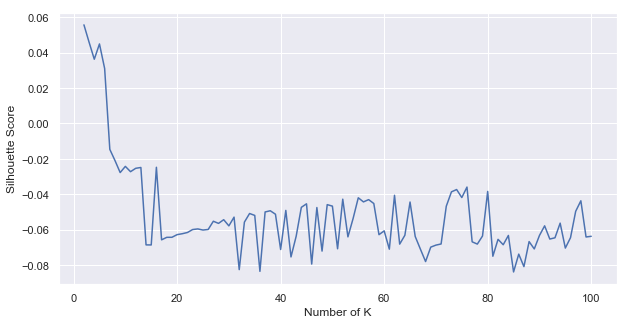

In [9]:
# Silhouette Score Result
plt.rcParams["figure.figsize"] = (10,5)
plt.xlabel("Number of K")
plt.ylabel("Silhouette Score")

x = [k for k in range(2, kmax + 1)]
y = silhouette_scores
plt.plot(x,y)

##### KMeans Clustering

In [8]:
training = True
if training:
    n_clusters = 10
    trained_vectors = [model.docvecs[i] for i in range(len(model.docvecs))]
    print('clustering...')
    kmeans = KMeans(n_clusters=n_clusters).fit(trained_vectors)
    clusters = kmeans.labels_.tolist()

    # save the model
    pickle.dump(kmeans, open('model/kmeans.pkl','wb'))
    print('clustering done')
else:
    print('load model...')
    kmeans = pickle.load(open('model/kmeans.pkl', 'rb'))
    print('load model done')

clustering...
clustering done


In [9]:
# create dictionary doc-id to cluster-id
docs_clusters = {(idx, cluster) for idx, cluster in enumerate(clusters)}

clusters_docs = {}
for item in docs_clusters:
    if item[1] in clusters_docs.keys():
        clusters_docs[item[1]].append(item[0])
    else:
        clusters_docs[item[1]] = []
        clusters_docs[item[1]].append(item[0])

##### Draw Cluster Diagram

In [10]:
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.text import Annotation

class Annotation3D(Annotation):
    '''Annotate the point xyz with text s'''

    def __init__(self, s, xyz, *args, **kwargs):
        Annotation.__init__(self,s, xy=(0,0), *args, **kwargs)
        self._verts3d = xyz        

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.xy=(xs,ys)
        Annotation.draw(self, renderer)

def annotate3D(ax, s, *args, **kwargs):
    '''add anotation text s to to Axes3d ax'''

    tag = Annotation3D(s, *args, **kwargs)
    ax.add_artist(tag)

In [11]:
centroids = kmeans.cluster_centers_

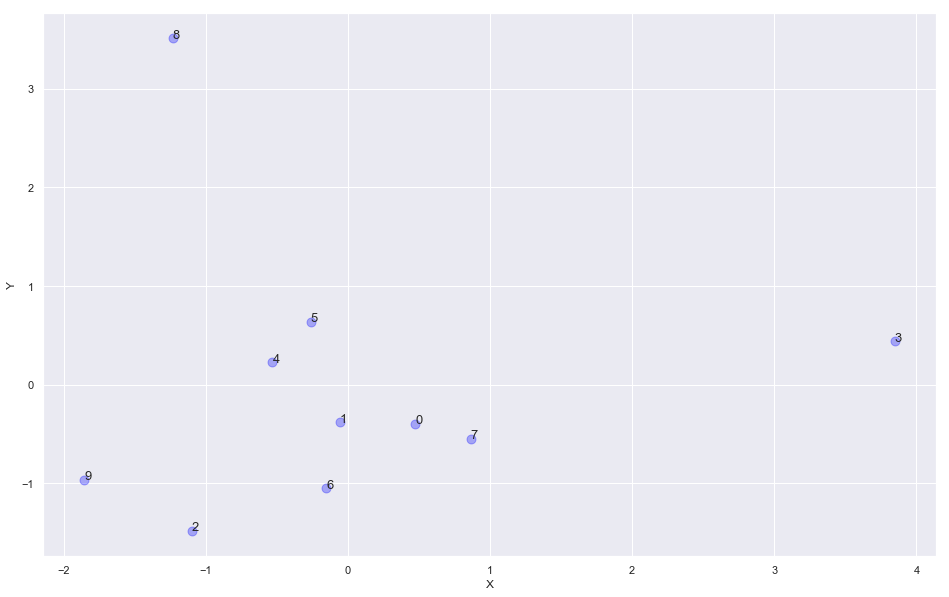

In [12]:
pca_result = PCA(n_components=2).fit_transform(centroids)
ax = plt.figure(figsize=(16,10)).gca()
ax.scatter(
    x=pca_result[:,0],
    y=pca_result[:,1],
    c='blue',
    s=80,
    alpha=0.3,
    cmap='tab10'
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
for i in range(0, n_clusters):
    ax.annotate(str(i), (pca_result[i:i+1,0], pca_result[i:i+1,1]), fontsize=13)

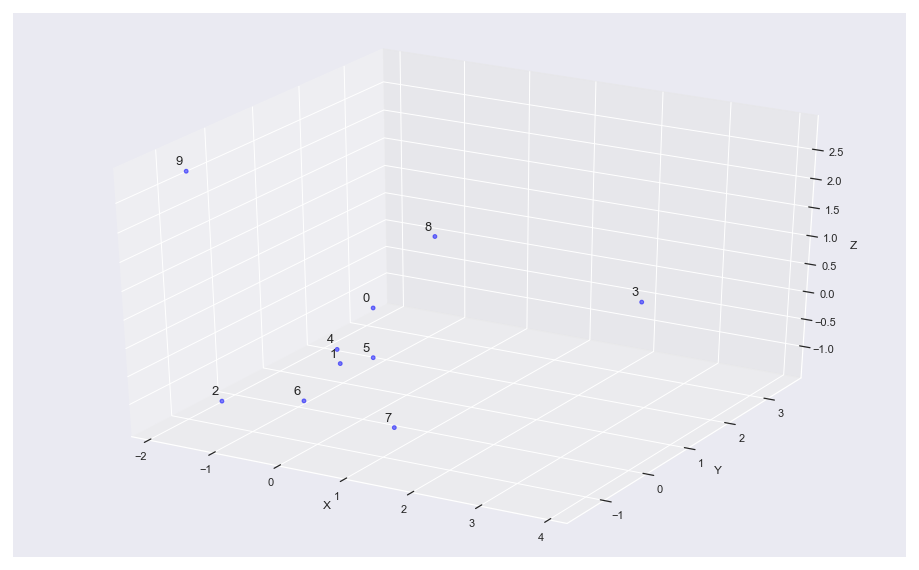

In [13]:
pca_result = PCA(n_components=3).fit_transform(centroids)
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result[:,0],
    ys=pca_result[:,1],
    zs=pca_result[:,2],
    c='blue',
    s=15,
    alpha=0.5,
    cmap='tab10'
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

xyzn = zip(pca_result[:,0], pca_result[:,1], pca_result[:,2])
# add vertices annotation.
for j, xyz_ in enumerate(xyzn): 
    annotate3D(ax, s=str(j), xyz=xyz_, fontsize=13, xytext=(-3,3), textcoords='offset points', ha='right', va='bottom')

##### Draw Documents Cluster

Text(0,0.5,'Y')

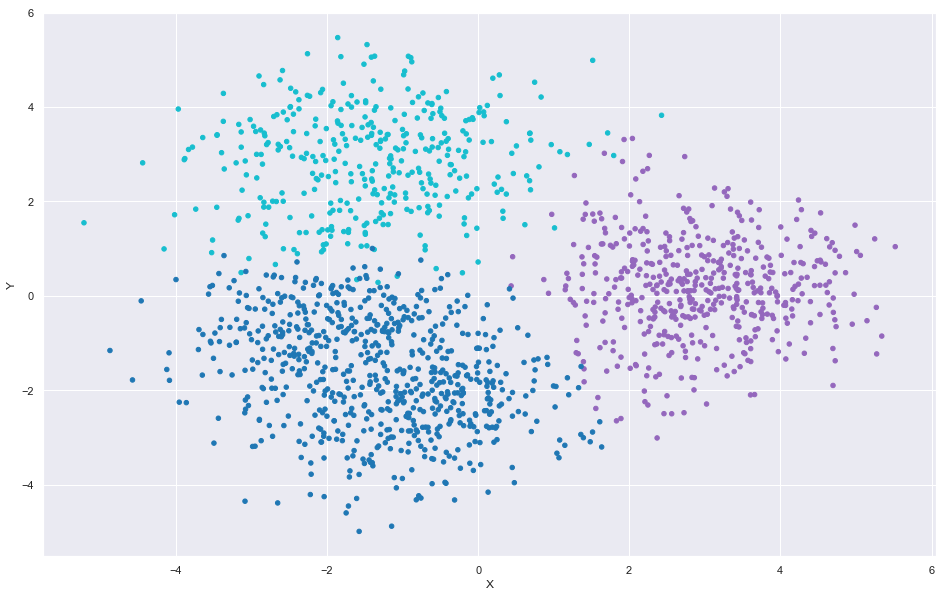

In [14]:
cluster_A = 5
cluster_B = 9
cluster_C = 2
X = [model.docvecs[i] for i in clusters_docs[cluster_A]] + \
    [model.docvecs[i] for i in clusters_docs[cluster_B]] + \
    [model.docvecs[i] for i in clusters_docs[cluster_C]]

Y = kmeans.predict(X)
pca_result = PCA(n_components=2).fit_transform(X)

ax = plt.figure(figsize=(16,10)).gca()
ax.scatter(
    x=pca_result[:,0],
    y=pca_result[:,1],
    c=Y,
    s=20,
    cmap='tab10'
)
ax.set_xlabel('X')
ax.set_ylabel('Y')

Text(0.5,0,'Z')

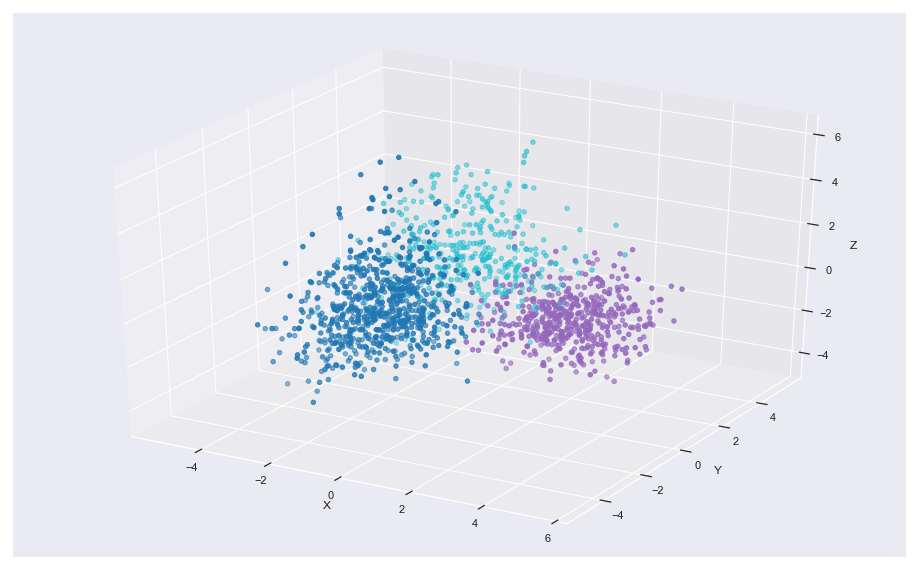

In [15]:
Y = kmeans.predict(X)
pca_result = PCA(n_components=3).fit_transform(X)

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result[:,0],
    ys=pca_result[:,1],
    zs=pca_result[:,2],
    c=Y,
    s=20,
    cmap='tab10'
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')